In [1]:
import pandas as pd
import numpy as np
import keras
from keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

In [2]:
df = pd.read_csv("/Users/gim-yuseong/Desktop/PycharmProjects/2024_3_2/2024_3_2_딥러닝응용/DSA_features.csv")
df

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,sitting,p1
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,sitting,p1
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,sitting,p1
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,sitting,p1
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,sitting,p1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9115,8.280854,34.1980,-2.9038,28.080803,5.299132,1.350075,-1.491537,11.2240,-11.65100,14.670334,...,0.200829,-0.040701,0.297666,0.708480,-0.117430,4.135451e-02,0.203358,-0.310022,basketBall,p8
9116,9.591118,51.6970,-3.4129,35.722025,5.976791,2.981144,0.086304,6.9951,-11.76400,5.329897,...,0.148745,-0.266377,0.224716,0.554670,-0.250950,3.355704e-02,0.183186,-0.736410,basketBall,p8
9117,9.599113,27.9300,-1.0765,48.850886,6.989341,0.449237,-0.728367,3.7801,-8.36910,5.683022,...,0.310748,-0.009505,-0.237786,0.088854,-0.477260,2.026107e-02,0.142341,0.668438,basketBall,p8
9118,9.692482,72.7820,-2.6734,59.378336,7.705734,4.491114,-0.582724,6.1216,-8.85710,4.162963,...,0.156493,0.050624,0.533023,0.677800,0.055941,1.356379e-02,0.116464,-1.482489,basketBall,p8


In [3]:
def split_sequences(sequences, n_steps, n_features):
    X, y = list(), list()
    for i in range(len(sequences)):
        # 시퀀스의 끝점 계산
        end_ix = i + n_steps
        # 데이터 범위를 넘어서면 중단
        if end_ix > len(sequences):
            break
        # 입력 시퀀스는 n_steps 동안의 데이터 (마지막 레이블 제외)
        seq_x = sequences[i:end_ix, :n_features]
        # 출력은 end_ix 시점에서 30개의 레이블만 가져옴
        seq_y = sequences[end_ix-1, n_features:]  # 특정 시점에서 한 번에 30개의 레이블만 가져오기
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [4]:
df_filtered = df.drop('activity', axis=1)
df_filtered.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,people
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,6.267229e-07,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,p1
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,7.403458e-07,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,p1
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,5.802523e-07,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,p1
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,5.398837e-07,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,p1
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,6.787533e-07,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,p1


In [5]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoder 객체 생성
label_encoder = LabelEncoder()

# 'label' 컬럼을 숫자로 변환
df_filtered['people'] = label_encoder.fit_transform(df_filtered['people'])

df_filtered.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,people
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,6.267229e-07,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,0
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,7.403458e-07,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,0
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,5.802523e-07,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,0
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,5.398837e-07,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,0
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,6.787533e-07,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,0


In [6]:
from sklearn.preprocessing import StandardScaler

# StandardScaler 객체 생성
scaler = StandardScaler()

# 열 이름의 접두사/접미사를 사용하여 필터링
prefixes = ['T_', 'RA_', 'LA_', 'RL_', 'LL_']  # 원하는 접두사 리스트
columns_to_scale = df_filtered.columns[df_filtered.columns.str.startswith(tuple(prefixes))]

# 선택한 열을 스케일링
df_filtered[columns_to_scale] = scaler.fit_transform(df_filtered[columns_to_scale])

# 스케일링 후 데이터 확인
df_filtered.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,people
0,0.055870,-0.546828,0.725530,-0.393761,-0.680020,-0.428085,0.860379,-0.148110,1.180617,-0.523874,...,-0.763476,-1.258551,0.441264,-0.350861,-0.623732,-0.017723,-0.400560,-0.913563,0.204309,0
1,0.056545,-0.545491,0.754858,-0.393913,-0.689658,0.321260,0.886595,-0.141000,1.195850,-0.524238,...,-0.763471,-1.257727,-0.439297,-0.351291,-0.623682,-0.018691,-0.400558,-0.913325,0.705828,0
2,0.054587,-0.553129,0.754823,-0.394011,-0.698774,-0.266880,0.886639,-0.141024,1.201248,-0.524308,...,-0.763478,-1.258909,-0.149907,-0.350716,-0.623032,-0.017234,-0.400562,-0.914056,0.218593,0
3,0.045943,-0.551243,0.726917,-0.393997,-0.697102,-0.699580,0.897675,-0.116077,1.201022,-0.523883,...,-0.763479,-1.259232,0.145985,-0.348852,-0.620142,-0.015135,-0.400553,-0.912443,0.533490,0
4,0.038098,-0.549365,0.752191,-0.394041,-0.702816,2.260389,0.907779,-0.130346,1.204990,-0.524269,...,-0.763474,-1.258165,-0.176094,-0.347060,-0.619151,-0.013759,-0.400559,-0.913492,0.562119,0


In [7]:
df_filtered['people'].value_counts()

people
0    1140
1    1140
2    1140
3    1140
4    1140
5    1140
6    1140
7    1140
Name: count, dtype: int64

In [8]:
X=df_filtered.drop(['people'], axis=1)

X.head()
# head()는 첫 5행만 출력함.

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_min,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew
0,0.055870,-0.546828,0.725530,-0.393761,-0.680020,-0.428085,0.860379,-0.148110,1.180617,-0.523874,...,0.519750,-0.763476,-1.258551,0.441264,-0.350861,-0.623732,-0.017723,-0.400560,-0.913563,0.204309
1,0.056545,-0.545491,0.754858,-0.393913,-0.689658,0.321260,0.886595,-0.141000,1.195850,-0.524238,...,0.519916,-0.763471,-1.257727,-0.439297,-0.351291,-0.623682,-0.018691,-0.400558,-0.913325,0.705828
2,0.054587,-0.553129,0.754823,-0.394011,-0.698774,-0.266880,0.886639,-0.141024,1.201248,-0.524308,...,0.522510,-0.763478,-1.258909,-0.149907,-0.350716,-0.623032,-0.017234,-0.400562,-0.914056,0.218593
3,0.045943,-0.551243,0.726917,-0.393997,-0.697102,-0.699580,0.897675,-0.116077,1.201022,-0.523883,...,0.523062,-0.763479,-1.259232,0.145985,-0.348852,-0.620142,-0.015135,-0.400553,-0.912443,0.533490
4,0.038098,-0.549365,0.752191,-0.394041,-0.702816,2.260389,0.907779,-0.130346,1.204990,-0.524269,...,0.521765,-0.763474,-1.258165,-0.176094,-0.347060,-0.619151,-0.013759,-0.400559,-0.913492,0.562119


In [9]:
y=df_filtered['people']
y.value_counts()

people
0    1140
1    1140
2    1140
3    1140
4    1140
5    1140
6    1140
7    1140
Name: count, dtype: int64

In [10]:
#one hot encoding 하기

y = pd.get_dummies(y).values
y

array([[ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False,  True]])

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
# random_state는 데이터를 무작위로 나누거나 섞을 때 사용되는 난수 발생기의 시드(seed) 값
X_train

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_min,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew
3482,0.419664,-0.267410,0.857712,-0.390597,-0.599402,1.766596,0.482579,0.143300,0.265497,0.011474,...,-1.464914,-0.601034,-0.523085,0.232655,0.164311,0.185977,0.191275,-0.180076,0.084982,-0.048766
5048,0.289253,-0.130556,0.213787,-0.261283,-0.001363,-0.372821,0.436366,0.152278,0.322950,-0.294576,...,-0.289184,1.336399,1.410150,-0.814559,0.074818,-0.022785,-0.026008,-0.196340,0.046971,-1.477950
8682,0.444226,0.915389,-2.387490,0.204361,0.799904,-0.827652,0.043703,1.562785,-2.802558,2.130162,...,0.241955,0.383108,0.710981,-1.315558,-0.538672,0.228596,-1.480582,1.839287,2.296963,-0.709158
85,0.496390,-0.415049,1.058778,-0.394059,-0.705942,-0.459722,-0.045746,-0.608613,0.669579,-0.523371,...,1.269129,-0.763475,-1.258426,0.286603,1.653274,1.306226,1.911123,-0.400556,-0.912833,-0.056411
4265,0.538101,-0.008419,0.135068,-0.261913,-0.003057,-0.541621,0.121592,0.302675,0.079200,-0.170676,...,-2.371487,0.405519,0.730228,-0.567322,-0.073746,-0.004433,-0.195205,-0.131990,0.189819,-0.729581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4373,0.448697,-0.124381,0.328237,-0.307457,-0.138625,-0.462540,0.429048,0.118952,0.069884,-0.128048,...,0.357864,0.096386,0.445775,0.001467,0.274422,0.274102,0.428105,-0.309710,-0.277118,1.695668
7891,0.079846,-0.287456,-0.615208,-0.257268,0.009345,-1.447639,0.592660,0.114140,0.305071,-0.256926,...,1.806422,-0.533621,-0.381912,0.502539,-0.212061,-0.170021,-0.120088,-0.231851,-0.041680,0.676274
4859,0.407423,0.029474,0.181631,-0.247453,0.034875,-0.042758,0.554886,0.498584,0.363278,-0.156013,...,0.479237,0.124998,0.474054,-1.003366,0.144897,0.166931,0.271166,-0.325120,-0.334718,0.993850
3264,0.077620,-0.529928,0.708385,-0.392884,-0.647255,-1.301710,-0.200471,-0.681803,0.576770,-0.523078,...,-0.962090,-0.469174,-0.265364,0.052740,0.519024,0.595645,0.377782,0.188570,0.726753,-0.505567


In [12]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [13]:
def build_model(
    input_shape,
    n_outputs,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks, # 해당 파라미터 값을 변경하여 적용한다.
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_outputs, activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [14]:
# Merge train and test X/y data to apply sequence transformation function
y_train_array = np.array(y_train)
# np.c_ : 배열을 열 방향으로 이어붙인다.
train_set = np.c_[X_train, y_train_array]

y_test_array = np.array(y_test)
test_set = np.c_[X_test, y_test_array]

print(test_set)

[[ 0.06956998 -0.33279226  0.28423533 ...  0.          1.
   0.        ]
 [ 0.49655011  0.00562165  0.46909816 ...  0.          0.
   1.        ]
 [ 0.08805305 -0.43553441  0.55706541 ...  0.          0.
   0.        ]
 ...
 [ 0.11132853  0.94972965 -0.48450524 ...  0.          1.
   0.        ]
 [ 0.15083931 -0.07946817  0.10737598 ...  0.          1.
   0.        ]
 [ 0.51992305 -0.01789223  0.25648989 ...  0.          0.
   1.        ]]


In [15]:
# Apply sequence transformation using time step of 25 for both train and test data
# All sensing modalities are recorded at a sampling rate of 50 Hz, which is considered sufficient for capturing human activity.

X_train, y_train = split_sequences(train_set, 5, X_test.shape[1])
print(X_train.shape, y_train.shape)

X_test, y_test = split_sequences(test_set, 5, X_test.shape[1])
print(X_test.shape, y_test.shape)

(6836, 5, 270) (6836, 8)
(2276, 5, 270) (2276, 8)


In [16]:
n_classes = len(np.unique(y_train))

idx = np.random.permutation(len(X_train))
X_train = X_train[idx]
y_train = y_train[idx]

y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

n_classes

2

In [17]:
# 각각 스텝 수, feature 수, label 수
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
print(n_timesteps, n_features, n_outputs)

5 270 8


In [18]:
input_shape = X_train.shape[1:]
input_shape

(5, 270)

In [19]:

model = build_model(
    input_shape,
    n_outputs,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=1,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)


model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["accuracy"],
)
model.summary()

# callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

model_history=model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=64,
#    callbacks=callbacks,
)

y_pred = model.predict(X_test)
y_test_class = np.argmax(y_test, axis=1) # 배열에서 최댓값을 가지는 원소의 인덱스를 반환하는 함수
y_pred_class = np.argmax(y_pred, axis=1)

model.evaluate(X_test, y_test, verbose=1)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5, 270)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5, 270)    │  1,109,262 │ input_layer[0][0… │
│ (MultiHeadAttentio… │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 5, 270)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 5, 270)    │        540 │ dropout_1[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 5, 270)    │          0 │ layer_normalizat… │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 5, 4)      │      1,084 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 5, 4)      │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 5, 270)    │      1,350 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 270)    │        540 │ conv1d_1[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 5, 270)    │          0 │ layer_normalizat… │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 270)       │          0 │ add_1[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     34,688 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 8)         │      1,032 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,148,496 (4.38 MB)

 Trainable params: 1,148,496 (4.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.1467 - loss: 2.5372 - val_accuracy: 0.2032 - val_loss: 2.0394
Epoch 2/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.1892 - loss: 2.0764 - val_accuracy: 0.2222 - val_loss: 1.9969
Epoch 3/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.2359 - loss: 2.0118 - val_accuracy: 0.2303 - val_loss: 1.9892
Epoch 4/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.2469 - loss: 1.9736 - val_accuracy: 0.2273 - val_loss: 1.9794
Epoch 5/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.2647 - loss: 1.9208 - val_accuracy: 0.2346 - val_loss: 1.9717
Epoch 6/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.2806 - loss: 1.8919 - val_accuracy: 0.2471 - val_loss: 1.9468
Epoch 7/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.2993 - loss: 1.8533 - val_accuracy: 0.2485 - val_loss: 1.9640
Epoch 8/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.3027 - loss: 1.8464 - val_accuracy: 0.

86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.4862 - loss: 1.3728 - val_accuracy: 0.2485 - val_loss: 2.1763
Epoch 52/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.4904 - loss: 1.3727 - val_accuracy: 0.2434 - val_loss: 2.2072
Epoch 53/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.4989 - loss: 1.3590 - val_accuracy: 0.2449 - val_loss: 2.2210
Epoch 54/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.4914 - loss: 1.3538 - val_accuracy: 0.2456 - val_loss: 2.2039
Epoch 55/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.5025 - loss: 1.3464 - val_accuracy: 0.2471 - val_loss: 2.2318
Epoch 56/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.4947 - loss: 1.3404 - val_accuracy: 0.2449 - val_loss: 2.2429
Epoch 57/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.5098 - loss: 1.3126 - val_accuracy: 0.2493 - val_loss: 2.2587
Epoch 58/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.5102 - loss: 1.3239 - val_accuracy: 0.2449 

86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.6195 - loss: 1.0232 - val_accuracy: 0.2361 - val_loss: 2.6289
Epoch 102/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.6377 - loss: 0.9882 - val_accuracy: 0.2339 - val_loss: 2.6488
Epoch 103/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.6277 - loss: 1.0108 - val_accuracy: 0.2251 - val_loss: 2.6782
Epoch 104/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.6416 - loss: 0.9902 - val_accuracy: 0.2376 - val_loss: 2.6694
Epoch 105/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.6372 - loss: 0.9861 - val_accuracy: 0.2529 - val_loss: 2.6701
Epoch 106/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.6276 - loss: 0.9721 - val_accuracy: 0.2354 - val_loss: 2.7125
Epoch 107/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.6436 - loss: 0.9598 - val_accuracy: 0.2500 - val_loss: 2.7022
Epoch 108/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.6395 - loss: 0.9696 - val_accuracy: 

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2860 - loss: 2.8058


[2.8120007514953613, 0.29261863231658936]

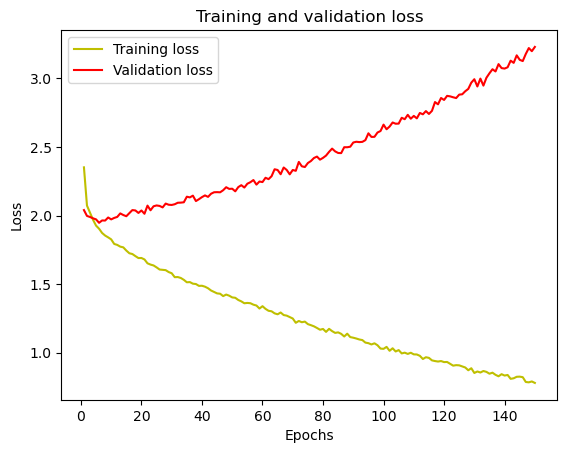

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix

# 훈련 손실(training loss)과 검증 손실(validation loss) 추출
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

# 에포크(epoch) 범위 생성
epochs = range(1, len(loss) + 1)

# 훈련 손실(training loss)과 검증 손실(validation loss) 시각화
plt.plot(epochs, loss, 'y', label='Training loss')  # 훈련 손실을 노란색(yellow)으로 플롯
plt.plot(epochs, val_loss, 'r', label='Validation loss')  # 검증 손실을 빨간색(red)으로 플롯
plt.title('Training and validation loss')  # 그래프 제목 설정
plt.xlabel('Epochs')  # x축 레이블 설정
plt.ylabel('Loss')  # y축 레이블 설정
plt.legend()  # 범례(legend) 표시
plt.show()  # 그래프 출력

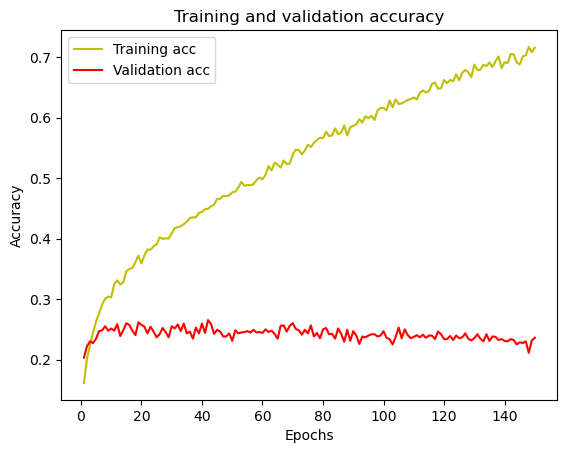

In [21]:
acc =model_history.history['accuracy']
val_acc =model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
print("\n----------------classification_report-----------------")
print(classification_report(y_test_class, y_pred_class))
print("\n------------------confusion_matrix--------------------")
print(confusion_matrix(y_test_class, y_pred_class))


----------------classification_report-----------------
              precision    recall  f1-score   support

           0       0.30      0.33      0.31       288
           1       0.30      0.28      0.29       280
           2       0.32      0.30      0.31       297
           3       0.26      0.26      0.26       288
           4       0.30      0.33      0.31       283
           5       0.27      0.25      0.26       294
           6       0.31      0.33      0.32       285
           7       0.29      0.26      0.27       261

    accuracy                           0.29      2276
   macro avg       0.29      0.29      0.29      2276
weighted avg       0.29      0.29      0.29      2276


------------------confusion_matrix--------------------
[[95 24 30 28 28 36 23 24]
 [30 78 24 16 32 36 26 38]
 [28 32 89 39 38 17 31 23]
 [35 26 29 76 26 30 36 30]
 [31 30 22 29 92 20 34 25]
 [37 29 23 38 39 74 39 15]
 [34 17 31 31 28 35 94 15]
 [28 25 28 33 28 28 23 68]]
